In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("20-digitalskysurvey.csv")

In [3]:
df.head(2)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541


In [4]:
columns_to_drop = ["objid","specobjid","rerun","camcol","field","run"]

In [5]:
df.drop(columns_to_drop,axis=1, inplace = True)

In [6]:
df["class"].value_counts()

class
GALAXY    4998
STAR      4152
QSO        850
Name: count, dtype: int64

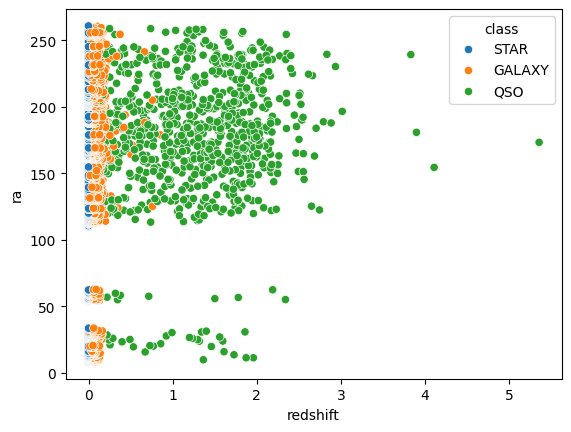

In [7]:
sns.scatterplot(data=df, x="redshift", y="ra", hue="class")
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

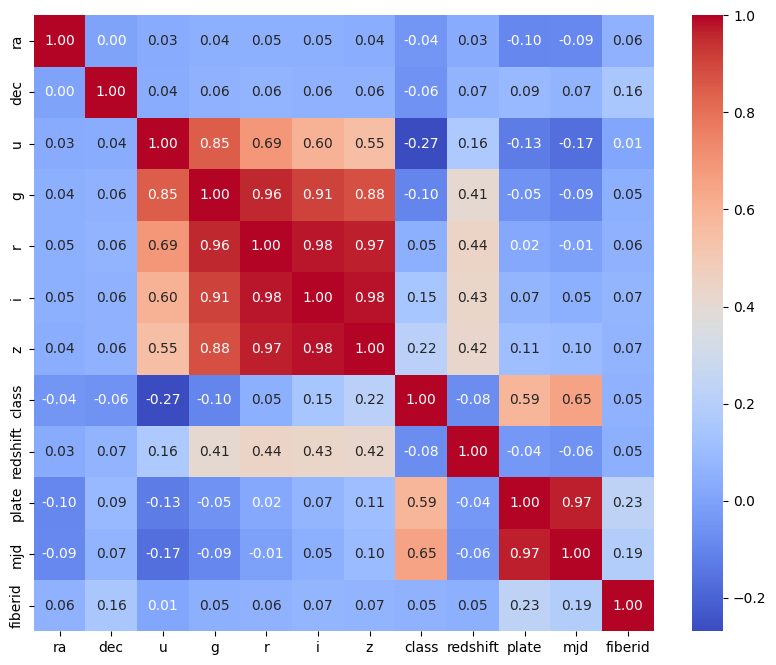

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Text(0.5, 1.0, 'QSO')

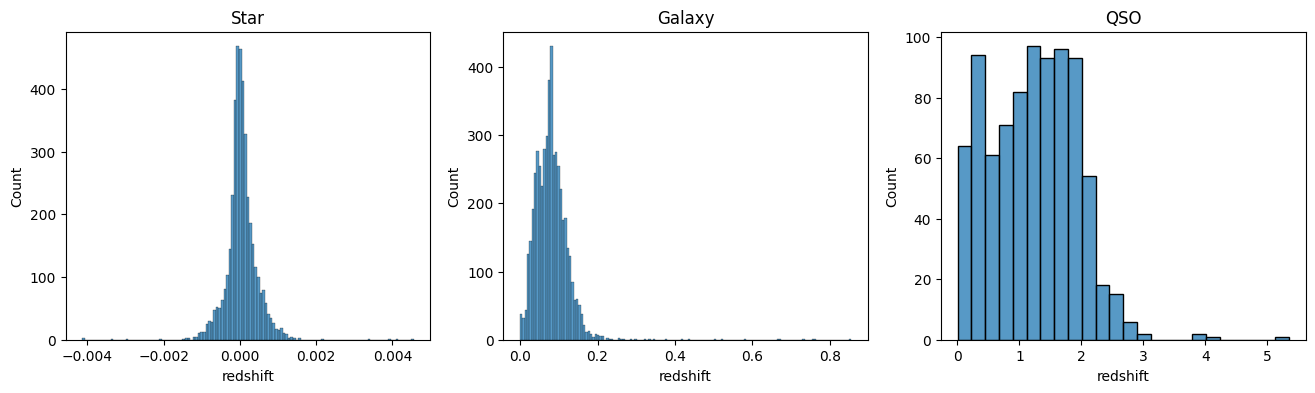

In [11]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
ax = sns.histplot(df[df["class"] == 2].redshift, ax = axes[0])
ax.set_title("Star")
ax = sns.histplot(df[df["class"] == 0].redshift, ax = axes[1])
ax.set_title("Galaxy")
ax = sns.histplot(df[df["class"] == 1].redshift, ax = axes[2])
ax.set_title("QSO")

In [12]:
def drop_high_corr(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    to_drop = [
        column for column in upper.columns 
        if any(upper[column] > threshold)
    ]
    
    print("Silinen kolonlar:", to_drop)

    df_clean = df.drop(columns=to_drop)

    print("\nYeni DataFrame:")
    print(df_clean.head())

    return df_clean


In [13]:
df_clean = drop_high_corr(df, threshold=0.95)

print(df_clean.head())      # ilk 5 satır
print(df_clean.shape)       # kaç satır, kaç sütun kaldı


Silinen kolonlar: ['r', 'i', 'z', 'mjd']

Yeni DataFrame:
           ra       dec         u         g  class  redshift  plate  fiberid
0  183.531326  0.089693  19.47406  17.04240      2 -0.000009   3306      491
1  183.598370  0.135285  18.66280  17.21449      2 -0.000055    323      541
2  183.680207  0.126185  19.38298  18.19169      0  0.123111    287      513
3  183.870529  0.049911  17.76536  16.60272      2 -0.000111   3306      510
4  183.883288  0.102557  17.55025  16.26342      2  0.000590   3306      512
           ra       dec         u         g  class  redshift  plate  fiberid
0  183.531326  0.089693  19.47406  17.04240      2 -0.000009   3306      491
1  183.598370  0.135285  18.66280  17.21449      2 -0.000055    323      541
2  183.680207  0.126185  19.38298  18.19169      0  0.123111    287      513
3  183.870529  0.049911  17.76536  16.60272      2 -0.000111   3306      510
4  183.883288  0.102557  17.55025  16.26342      2  0.000590   3306      512
(10000, 8)


In [14]:
X = df.drop("class", axis = 1)
y = df["class"]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33)

In [17]:
scaler = StandardScaler()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   class     10000 non-null  int64  
 8   redshift  10000 non-null  float64
 9   plate     10000 non-null  int64  
 10  mjd       10000 non-null  int64  
 11  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 937.6 KB


In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
#!pip install xgboost

In [21]:
from xgboost import XGBClassifier

In [22]:
xgb = XGBClassifier(n_estimators = 100)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9906060606060606
[[1630    6    7]
 [  16  284    1]
 [   1    0 1355]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1643
           1       0.98      0.94      0.96       301
           2       0.99      1.00      1.00      1356

    accuracy                           0.99      3300
   macro avg       0.99      0.98      0.98      3300
weighted avg       0.99      0.99      0.99      3300



In [25]:
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 1.0
Test Accuracy: 0.9906060606060606


In [26]:
params = {
    "n_estimators" : [100,200,300,500],
    "learning_rate" : [0.01, 0.1],
    "max_depth" : [5,8,12,20,30],
    "colsample_bytree" : [0.3,0.4,0.5,0.8,1] 
}

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
grid = GridSearchCV(estimator=XGBClassifier(), param_grid= params, cv = 5) # n_jobs = -1)

In [29]:
# grid.fit(X_train, y_train)

In [30]:
#grid.best_params

In [31]:
# y_pred = grid.predict(X_test)

In [32]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9906060606060606
[[1630    6    7]
 [  16  284    1]
 [   1    0 1355]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1643
           1       0.98      0.94      0.96       301
           2       0.99      1.00      1.00      1356

    accuracy                           0.99      3300
   macro avg       0.99      0.98      0.98      3300
weighted avg       0.99      0.99      0.99      3300

